### Packages

In [ ]:
import zipfile
from google.colab import drive
from PIL import Image

import re
import glob
import os
import imageio
import random
import math
import tempfile
import logging
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow
import keras

# Torch, scipy, medpy, skimage
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from skimage.transform import resize, rescale
from sklearn.model_selection import train_test_split


In [ ]:
# Check GPU avalibility
import torch
torch.cuda.is_available()

True

### Mount Google drive

In [ ]:
# Mount google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Variable settings

In [ ]:
# Variables (adjustable)
val_split = 0.1  
test_split = 0.1
downsample = 0.25

n_epochs = 1000
batch_size = 32
isReadimg = True
method = 'rgb_img'
info = 'aug_10_2_3'
#dataset = 'kinetic_leap'  
dataset = 'senz3d'
crop_rate = 0.5

if dataset == 'kinetic_leap':

  # People folders to use
  #people_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6','P7','P8', 'P9', 'P10'] 
  people_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']   
  # people_list = ['P1', 'P2', 'P3']  

  # Gesture folders to use
  gestures_list = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6','G7','G8', 'G9', 'G10'] 
  # gestures_list = ['G1', 'G2', 'G3'] 

  %cd '/content/drive/My Drive/CV_Dataset/kinetic_leap_dataset/'

elif dataset == 'senz3d':

  # People folders to use
  people_list = ['S1', 'S2', 'S3']   
  #people_list = ['S1']  

  # Gesture folders to use
  gestures_list = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6','G7','G8', 'G9', 'G10', 'G11']
  match_list = [5, 1, 1, 2 ,3, 5, 0, 2, 1, 4, 3]
  #gestures_list = ['G1']

  %cd '/content/drive/My Drive/CV_Dataset/senz3d_dataset/'


/content/drive/My Drive/CV_Dataset/senz3d_dataset


In [ ]:
def center_crop(img, dim):
    """
    Perform center cropping of an given image

    Args:
    img: input image to be cropped
    dim: 2-tuple that specifies the crop dimension
    """
    width, height = img.shape[1], img.shape[0]
    mid_x, mid_y = int(width/2), int(height/2)

    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 

    cw2,ch2 = int(crop_width/2), int(crop_height/2)
    crop_img = img[mid_x-cw2:mid_x+cw2, mid_y-ch2:mid_y+ch2]
    return crop_img

### Image loading

In [ ]:
n_gestures = len(np.unique(gestures_list))
n_people = len(people_list)

imgs = []
dimgs = []
confs = []
labels = []

data_name = 'p{}_g{}_ds{}_data.pt'.format(n_gestures, n_people, downsample)
data_save_path =  os.getcwd() + '/save/data/' + data_name
print(data_save_path)
# Load from saved file
if os.path.exists(data_save_path) and not isReadimg:
  print('Loading data from {}'.format(data_save_path))
  data_dict = torch.load(data_save_path)
else:
  # Read images  
  print('Reading image')
  for ppl in people_list:
    person_id = int(re.sub('[^0-9]', '', ppl))
    for gest in gestures_list:
      gest_id = int(re.sub('[^0-9]', '', gest))
      print('Loading person {} gesture {}'.format(person_id, gest_id))
      base_path = os.getcwd() + '/acquisitions/' + ppl + '/' + gest

      if dataset == 'kinetic_leap':
        img_paths = glob.glob(base_path + '/*_rgb.png')
        dimg_paths = glob.glob(base_path + '/*_depth.png')
        assert len(img_paths) == len(dimg_paths)

        for i in range(len(img_paths)):
          img = imageio.imread(img_paths[i])
          dimg = imageio.imread(dimg_paths[i])
          img_rs = rescale(img, downsample, anti_aliasing=True)
          dimg_rs = rescale(dimg, downsample, anti_aliasing=True)
          imgs.append(img_rs)
          dimgs.append(dimg_rs)
          labels.append(match_list[gest_id-1])

      elif dataset == 'senz3d':
        img_paths = glob.glob(base_path + '/*-color.png')
        dimg_paths = glob.glob(base_path + '/*-depth.bin')
        conf_paths = glob.glob(base_path + '/*-conf.bin')
        assert len(img_paths) == len(dimg_paths)

        for i in range(len(img_paths)):
          img = imageio.imread(img_paths[i])
          h = 240
          w = 320
          with open(dimg_paths[i], mode='rb') as f:
              dimg = np.fromfile(f,dtype=np.uint16,count=w*h).reshape(h,w)
              # plt.imshow(dimg)
              # plt.show()
              f.close()
          with open(dimg_paths[i], mode='rb') as f:
              conf = np.fromfile(f,dtype=np.uint16,count=w*h).reshape(h,w)
              f.close()
          img_rs = rescale(img, downsample, anti_aliasing=True, multichannel= True)
          dimg_rs = rescale(dimg, downsample*2, anti_aliasing=True)
          conf_rs = rescale(conf, downsample*2, anti_aliasing=True)

          # Center crop
          img_rs = center_crop(img_rs, (math.floor(img_rs.shape[0]*crop_rate), math.floor(img_rs.shape[1]*crop_rate)))
          dimg_rs = center_crop(dimg_rs, (math.floor(dimg_rs.shape[0]*crop_rate), math.floor(dimg_rs.shape[1]*crop_rate)))
          conf_rs = center_crop(conf_rs, (math.floor(conf_rs.shape[0]*crop_rate), math.floor(conf_rs.shape[1]*crop_rate)))

          imgs.append(img_rs)
          dimgs.append(dimg_rs)
          confs.append(conf_rs)
          labels.append(match_list[gest_id-1]+1)

  data_dict = {
      'imgs':imgs,
      'dimgs':dimgs,
      'labels':labels,
      'confs':confs
  }

  torch.save(data_dict, data_save_path)
  print('data saved to: {}'.format(data_save_path))

/content/drive/My Drive/CV_Dataset/senz3d_dataset/save/data/p11_g3_ds0.25_data.pt
Reading image
Loading person 1 gesture 1
Loading person 1 gesture 2
Loading person 1 gesture 3
Loading person 1 gesture 4
Loading person 1 gesture 5
Loading person 1 gesture 6
Loading person 1 gesture 7
Loading person 1 gesture 8
Loading person 1 gesture 9
Loading person 1 gesture 10
Loading person 1 gesture 11
Loading person 2 gesture 1
Loading person 2 gesture 2
Loading person 2 gesture 3
Loading person 2 gesture 4
Loading person 2 gesture 5
Loading person 2 gesture 6
Loading person 2 gesture 7
Loading person 2 gesture 8
Loading person 2 gesture 9
Loading person 2 gesture 10
Loading person 2 gesture 11
Loading person 3 gesture 1
Loading person 3 gesture 2
Loading person 3 gesture 3
Loading person 3 gesture 4
Loading person 3 gesture 5
Loading person 3 gesture 6
Loading person 3 gesture 7
Loading person 3 gesture 8
Loading person 3 gesture 9
Loading person 3 gesture 10
Loading person 3 gesture 11
data sa

### Visualize images & Preprocessing

(60, 80)
Image ID: 272 ; Label(gesture): 5
RGB image size: (60, 80, 3), Depth image size: (60, 80)


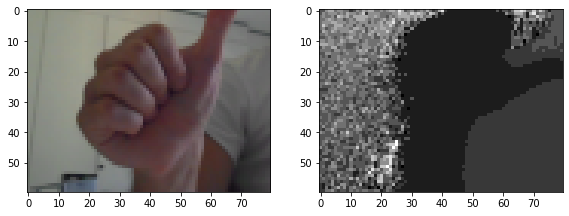

In [ ]:
imgs = data_dict['imgs']
dimgs = data_dict['dimgs']
labels = data_dict['labels']
confs = data_dict['confs']
imgs = np.array(imgs, dtype = 'float32')
dimgs = np.array(dimgs, dtype = 'float32')
labels = np.array(labels, dtype = 'int8')

(img_h, img_w, img_c) = imgs[0].shape
(dimg_h, dimg_w) = dimgs[0].shape
print(dimgs[0].shape)
# Check a random training image
random_id = random.randint(0, imgs.shape[0]-1)
print('Image ID: {} ; Label(gesture): {}'.format(random_id, labels[random_id]))
fig = plt.figure(figsize=(9.6, 12.8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow((255*imgs[random_id]).squeeze().astype(np.uint8), cmap='gray')
ax2 = fig.add_subplot(1,2,2)

ax2.imshow((255*dimgs[random_id]).squeeze().astype(np.uint8), cmap='gray')

print('RGB image size: {}, Depth image size: {}'.format(imgs[0].shape, dimgs[0].shape))
# print('RGB image range: {}'.format(np.unique(imgs[0])))
# print('Depth image range: {}'.format(np.unique(dimgs[0])))

# Some preprocessing
labels = keras.utils.to_categorical(labels-1)
imgs = imgs.reshape((len(imgs), imgs[0].shape[0], imgs[0].shape[1], imgs[0].shape[2]))
dimgs = dimgs.reshape((len(dimgs), dimgs[0].shape[0], dimgs[0].shape[1], 1))
tr_gen = keras.preprocessing.image.ImageDataGenerator(
      featurewise_center=True,
      featurewise_std_normalization=True,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True)
test_gen = keras.preprocessing.image.ImageDataGenerator(
      featurewise_center=True,
      featurewise_std_normalization=True)

### Train with img
if method == 'rgb_img':
  input_shape = (img_h, img_w, img_c)
  x_train = imgs.copy()
  y_train = labels.copy()

## Train with dimg
elif method == 'depth_img':
  input_shape = (dimg_h, dimg_w, 1)
  x_train = dimgs.copy()
  y_train = labels.copy()

x_train, x_further, y_train, y_further = train_test_split(x_train, y_train, test_size = val_split+test_split, shuffle=True)
x_validate, x_test, y_validate, y_test = train_test_split(x_further, y_further, test_size = test_split/(test_split+val_split), shuffle=True)

tr_gen.fit(x_train)
test_gen.fit(x_validate)

### Model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', input_shape=input_shape)) 
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(6, activation='softmax'))

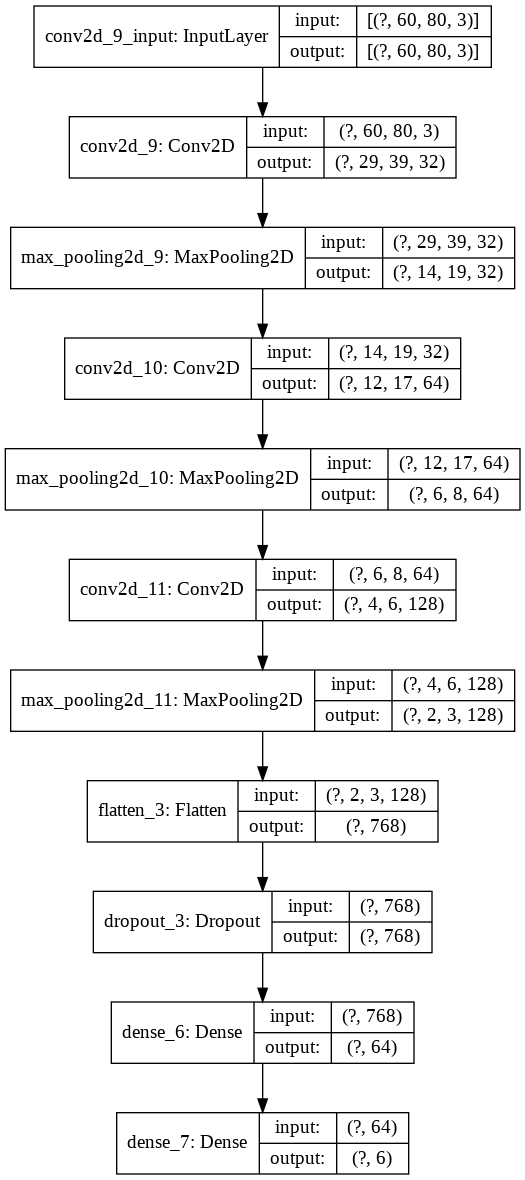

In [ ]:
dot_img_file = '/tmp/model.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### Training

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
tr_generator = tr_gen.flow(x_train, y_train, batch_size=batch_size)
val_generator = test_gen.flow(x_validate, y_validate, batch_size=batch_size)
history = model.fit(tr_generator, steps_per_epoch=len(x_train)/batch_size, epochs=n_epochs, batch_size=batch_size, verbose=2, validation_data=val_generator)

Epoch 1/1000
25/24 - 1s - loss: 1.7493 - accuracy: 0.2563 - val_loss: 1.7596 - val_accuracy: 0.2222
Epoch 2/1000
25/24 - 1s - loss: 1.7114 - accuracy: 0.2828 - val_loss: 1.7373 - val_accuracy: 0.2424
Epoch 3/1000
25/24 - 1s - loss: 1.7060 - accuracy: 0.2715 - val_loss: 1.7086 - val_accuracy: 0.2222
Epoch 4/1000
25/24 - 1s - loss: 1.7073 - accuracy: 0.2828 - val_loss: 1.7059 - val_accuracy: 0.2222
Epoch 5/1000
25/24 - 1s - loss: 1.6756 - accuracy: 0.2992 - val_loss: 1.6983 - val_accuracy: 0.2323
Epoch 6/1000
25/24 - 1s - loss: 1.6805 - accuracy: 0.2854 - val_loss: 1.6686 - val_accuracy: 0.2323
Epoch 7/1000
25/24 - 1s - loss: 1.6686 - accuracy: 0.2664 - val_loss: 1.6541 - val_accuracy: 0.2121
Epoch 8/1000
25/24 - 1s - loss: 1.6503 - accuracy: 0.3119 - val_loss: 1.6629 - val_accuracy: 0.2424
Epoch 9/1000
25/24 - 1s - loss: 1.6234 - accuracy: 0.3043 - val_loss: 1.6156 - val_accuracy: 0.2626
Epoch 10/1000
25/24 - 1s - loss: 1.6245 - accuracy: 0.3119 - val_loss: 1.6119 - val_accuracy: 0.2424

In [ ]:
test_generator = test_gen.flow(x_test, y_test, batch_size=batch_size)
[loss, acc] = model.evaluate(test_generator,verbose=1)

4/4 [==============================] - 0s 4ms/step - loss: 0.5170 - accuracy: 0.9091


In [ ]:
# timer.py

import time

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")

### Results

/content/drive/My Drive/CV_Dataset/senz3d_dataset/save/result/rgb_img_p11_g3_ds0.25_e1000_bs32_aug_10_2_3_acc0.909091_result.png


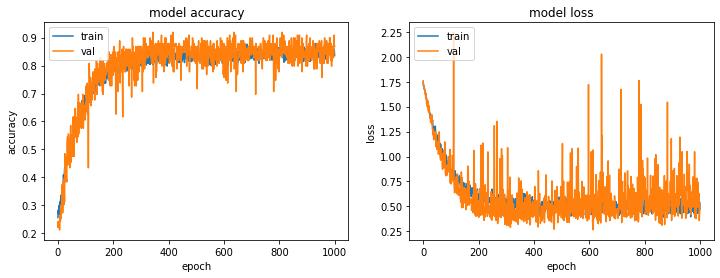

In [ ]:
# summarize history for accuracy
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,2,1)
# ax1.plot(history.history['accuracy'][0:300])
# ax1.plot(history.history['val_accuracy'][0:300])
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2 = fig.add_subplot(1,2,2)
# ax2.plot(history.history['loss'][0:300])
# ax2.plot(history.history['val_loss'][0:300])
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

result_name =  '{}_p{}_g{}_ds{}_e{}_bs{}_{}_acc{:2f}_result.png'.format(method, n_gestures, n_people, downsample, n_epochs, batch_size,info, acc)
result_save_path = os.getcwd() + '/save/result/' + result_name
print(result_save_path)
fig.savefig(result_save_path)

In [ ]:
model_name =  '{}_p{}_g{}_ds{}_e{}_bs{}_{}_acc{:2f}_model'.format(method, n_gestures, n_people, downsample, n_epochs, batch_size, info, acc)
model_save_path =  os.getcwd() + '/save/model/' + model_name
keras.models.save_model(model, model_save_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/CV_Dataset/senz3d_dataset/save/model/rgb_img_p11_g3_ds0.25_e1000_bs32_aug_10_2_3_acc0.909091_model/assets


In [ ]:
test_generator = test_gen.flow(x_test, y_test, batch_size=batch_size,shuffle=False)
[loss, acc] = model.evaluate(test_generator,verbose=1)
print("Accuracy:" + str(acc))

4/4 [==============================] - 0s 4ms/step - loss: 0.5170 - accuracy: 0.9091
Accuracy:0.9090909361839294


[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
Test image - Gesture label: G1
Test image - Gesture prediction: G1


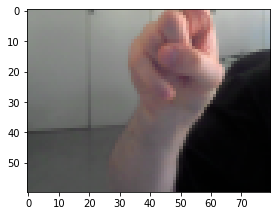

In [ ]:
test_example = next(test_generator)
test_input = test_example[0]
test_label = test_example[1]
random_id = random.randint(0, test_input.shape[0]-1)
test_img = test_input[random_id]
test_img = x_test[random_id]
test_img_pred = test_label[random_id]
test_img_label = y_test[random_id]

print(test_img_label)
print(test_img_pred)
print('Test image - Gesture label:', gestures_list[np.where(test_img_label==1)[0][0]])
print('Test image - Gesture prediction:', gestures_list[np.where(test_img_pred==1)[0][0]])
fig = plt.figure(figsize=(9.6, 12.8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow((255*test_img.squeeze()).astype(np.uint8), cmap='gray')

### Additional test set (evaluating using gestures from another person)

In [ ]:
# Variables (adjustable)
val_split = 0.1  
test_split = 0.1
downsample = 0.25

n_epochs = 800
batch_size = 32
isReadimg = True
method = 'rgb_img'
info = 'aug_10_2_3'
#dataset = 'kinetic_leap'  
dataset = 'senz3d'


if dataset == 'kinetic_leap':

  # People folders to use
  #people_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6','P7','P8', 'P9', 'P10'] 
  people_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']   
  # people_list = ['P1', 'P2', 'P3']  

  # Gesture folders to use
  gestures_list = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6','G7','G8', 'G9', 'G10'] 
  # gestures_list = ['G1', 'G2', 'G3'] 

  %cd '/content/drive/My Drive/CV_Dataset/kinetic_leap_dataset/'

elif dataset == 'senz3d':

  # People folders to use
  people_list = ['S4']  

  # Gesture folders to use
  gestures_list = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6','G7','G8', 'G9', 'G10', 'G11'] 
  #gestures_list = ['G1']

  %cd '/content/drive/My Drive/CV_Dataset/senz3d_dataset/'

/content/drive/My Drive/CV_Dataset/senz3d_dataset


In [ ]:

imgs = []
dimgs = []
confs = []
labels = []

data_name = 'p{}_g{}_ds{}_testdata.pt'.format(n_gestures, n_people, downsample)
data_save_path =  os.getcwd() + '/save/data/' + data_name
print(data_save_path)
# Load from saved file
if os.path.exists(data_save_path) and not isReadimg:
  print('Loading data from {}'.format(data_save_path))
  data_dict = torch.load(data_save_path)
else:
  # Read images  
  print('Reading image')
  for ppl in people_list:
    person_id = int(re.sub('[^0-9]', '', ppl))
    for gest in gestures_list:
      gest_id = int(re.sub('[^0-9]', '', gest))
      print('Loading person {} gesture {}'.format(person_id, gest_id))
      base_path = os.getcwd() + '/acquisitions/' + ppl + '/' + gest

      if dataset == 'kinetic_leap':
        img_paths = glob.glob(base_path + '/*_rgb.png')
        dimg_paths = glob.glob(base_path + '/*_depth.png')
        assert len(img_paths) == len(dimg_paths)

        for i in range(len(img_paths)):
          img = imageio.imread(img_paths[i])
          dimg = imageio.imread(dimg_paths[i])
          img_rs = rescale(img, downsample, anti_aliasing=True)
          dimg_rs = rescale(dimg, downsample, anti_aliasing=True)
          imgs.append(img_rs)
          dimgs.append(dimg_rs)
          labels.append(gest_id)

      elif dataset == 'senz3d':
        img_paths = glob.glob(base_path + '/*-color.png')
        dimg_paths = glob.glob(base_path + '/*-depth.bin')
        conf_paths = glob.glob(base_path + '/*-conf.bin')
        assert len(img_paths) == len(dimg_paths)

        for i in range(len(img_paths)):
          img = imageio.imread(img_paths[i])
          h = 240
          w = 320
          with open(dimg_paths[i], mode='rb') as f:
              dimg = np.fromfile(f,dtype=np.uint16,count=w*h).reshape(h,w)
              # plt.imshow(dimg)
              # plt.show()
              f.close()
          with open(dimg_paths[i], mode='rb') as f:
              conf = np.fromfile(f,dtype=np.uint16,count=w*h).reshape(h,w)
              f.close()
          img_rs = rescale(img, downsample, anti_aliasing=True, multichannel= True)
          dimg_rs = rescale(dimg, downsample*2, anti_aliasing=True)
          conf_rs = rescale(conf, downsample*2, anti_aliasing=True)
          # Center crop
          img_rs = center_crop(img_rs, (math.floor(img_rs.shape[0]*crop_rate), math.floor(img_rs.shape[1]*crop_rate)))
          dimg_rs = center_crop(dimg_rs, (math.floor(dimg_rs.shape[0]*crop_rate), math.floor(dimg_rs.shape[1]*crop_rate)))
          conf_rs = center_crop(conf_rs, (math.floor(conf_rs.shape[0]*crop_rate), math.floor(conf_rs.shape[1]*crop_rate)))

          imgs.append(img_rs)
          dimgs.append(dimg_rs)
          confs.append(conf_rs)
          labels.append(match_list[gest_id-1]+1)


  data_dict = {
      'imgs':imgs,
      'dimgs':dimgs,
      'labels':labels,
      'confs':confs
  }

  torch.save(data_dict, data_save_path)
  print('data saved to: {}'.format(data_save_path))

/content/drive/My Drive/CV_Dataset/senz3d_dataset/save/data/p11_g3_ds0.25_testdata.pt
Reading image
Loading person 4 gesture 1
Loading person 4 gesture 2
Loading person 4 gesture 3
Loading person 4 gesture 4
Loading person 4 gesture 5
Loading person 4 gesture 6
Loading person 4 gesture 7
Loading person 4 gesture 8
Loading person 4 gesture 9
Loading person 4 gesture 10
Loading person 4 gesture 11
data saved to: /content/drive/My Drive/CV_Dataset/senz3d_dataset/save/data/p11_g3_ds0.25_testdata.pt


(60, 80)
Image ID: 286 ; Label(gesture): 5
RGB image size: (60, 80, 3), Depth image size: (60, 80)


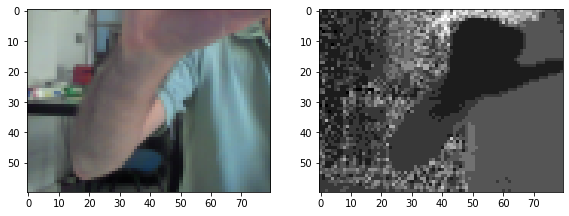

In [ ]:
imgs = data_dict['imgs']
dimgs = data_dict['dimgs']
labels = data_dict['labels']
confs = data_dict['confs']
imgs = np.array(imgs, dtype = 'float32')
dimgs = np.array(dimgs, dtype = 'float32')
labels = np.array(labels, dtype = 'int8')

(img_h, img_w, img_c) = imgs[0].shape
(dimg_h, dimg_w) = dimgs[0].shape
print(dimgs[0].shape)
# Check a random training image
random_id = random.randint(0, imgs.shape[0]-1)
print('Image ID: {} ; Label(gesture): {}'.format(random_id, labels[random_id]))
fig = plt.figure(figsize=(9.6, 12.8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow((255*imgs[random_id]).squeeze().astype(np.uint8), cmap='gray')
ax2 = fig.add_subplot(1,2,2)

ax2.imshow((255*dimgs[random_id]).squeeze().astype(np.uint8), cmap='gray')

print('RGB image size: {}, Depth image size: {}'.format(imgs[0].shape, dimgs[0].shape))
# print('RGB image range: {}'.format(np.unique(imgs[0])))
# print('Depth image range: {}'.format(np.unique(dimgs[0])))

# Some preprocessing
labels = keras.utils.to_categorical(labels-1)
imgs = imgs.reshape((len(imgs), imgs[0].shape[0], imgs[0].shape[1], imgs[0].shape[2]))
dimgs = dimgs.reshape((len(dimgs), dimgs[0].shape[0], dimgs[0].shape[1], 1))
test_gen = keras.preprocessing.image.ImageDataGenerator(
      featurewise_center=True,
      featurewise_std_normalization=True)

### Train with img
if method == 'rgb_img':
  input_shape = (img_h, img_w, img_c)
  x_train = imgs.copy()
  y_train = labels.copy()

## Train with dimg
elif method == 'depth_img':
  input_shape = (dimg_h, dimg_w, 1)
  x_train = dimgs.copy()
  y_train = labels.copy()

x_train, x_further, y_train, y_further = train_test_split(x_train, y_train, test_size = val_split+test_split, shuffle=True)

test_gen.fit(x_train)

In [ ]:
test_generator = test_gen.flow(x_train, y_train, batch_size=batch_size,shuffle=False)
[loss, acc] = model.evaluate(test_generator,verbose=1)
print("Accuracy:" + str(acc))

9/9 [==============================] - 0s 4ms/step - loss: 75.1305 - accuracy: 0.1894
Accuracy:0.18939393758773804
